In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, blend_models,tune_model,predict_model,get_config, finalize_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.family'] = 'Gulim'

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [9]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


## 전처리
- 일자에서 월과 일을 분리
- 요일을 레이블 인코딩화(EDA로 요일의 중요도 순 파악)
- 월 별, 일 별 중식 석식 수요 차이 파악

In [10]:
train['월'] = pd.DatetimeIndex(train['일자']).month.astype(int)
test['월'] = pd.DatetimeIndex(test['일자']).month.astype(int)
train['주'] = pd.DatetimeIndex(train['일자']).week.astype(int)
test['주'] = pd.DatetimeIndex(test['일자']).week.astype(int)
train['일'] = pd.DatetimeIndex(train['일자']).day.astype(int)
test['일'] = pd.DatetimeIndex(test['일자']).day.astype(int)

train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

## 공휴일 변수 생성

In [11]:
train['공휴일전후'] = 'N'
test['공휴일전후'] = 'N'

[4h, 17s, 152s, 221s, 226s, 245h, 309s, 310s,311s,330s,379s, 421h,502h,511s,565s,650h,651s,705s,709s,732h,815s,864s,951e,971h, 1038s,1129h, 1187e, ]

In [12]:
train['공휴일전후'][4] = 'H'
train['공휴일전후'][17] = 'S'
train['공휴일전후'][152] = 'S'
train['공휴일전후'][245] = 'H'
train['공휴일전후'][310] = 'S'
train['공휴일전후'][311] = 'S'
train['공휴일전후'][330] = 'S'
train['공휴일전후'][379] = 'S'
train['공휴일전후'][421] = 'H'
train['공휴일전후'][502] = 'H'
train['공휴일전후'][511] = 'S'
train['공휴일전후'][565] = 'S'
train['공휴일전후'][650] = 'H'
train['공휴일전후'][651] = 'S'
train['공휴일전후'][705] = 'C'
train['공휴일전후'][709] = 'S'
train['공휴일전후'][732] = 'H'
train['공휴일전후'][815] = 'S'
train['공휴일전후'][864] = 'S'
train['공휴일전후'][951] = 'C'
train['공휴일전후'][971] = 'H'
train['공휴일전후'][1038] = 'S'
train['공휴일전후'][1129] = 'H'
train['공휴일전후'][1187] = 'C'


test['공휴일전후'][10] = 'H'


## 최종 데이터 셋 구축

In [18]:
train = train[train['일자'] >= '2020-03-00']

In [19]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '월', '주', '일',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '공휴일전후'],
      dtype='object')

In [20]:
lunch_train = pd.concat([train[['요일','월','일','주','본사시간외근무명령서승인건수', '본사출장자수', '본사휴가자수', '본사정원수','현본사소속재택근무자수', '공휴일전후','출근', '휴가비율', '출장비율', '야근비율', '재택비율','중식계']]],axis=1)
lunch_test = pd.concat([test[['요일','월','일','주','본사시간외근무명령서승인건수', '본사출장자수', '본사휴가자수', '본사정원수','현본사소속재택근무자수', '공휴일전후','출근', '휴가비율', '출장비율', '야근비율', '재택비율']]],axis=1)


dinner_train = pd.concat([train[['요일','월','일','주','본사시간외근무명령서승인건수', '본사출장자수', '본사휴가자수', '본사정원수','현본사소속재택근무자수', '공휴일전후','출근', '휴가비율', '출장비율', '야근비율', '재택비율','석식계']]],axis=1)
dinner_test = pd.concat([test[['요일','월','일','주','본사시간외근무명령서승인건수', '본사출장자수', '본사휴가자수', '본사정원수','현본사소속재택근무자수', '공휴일전후','출근', '휴가비율', '출장비율', '야근비율', '재택비율']]],axis=1)

In [21]:
print(lunch_train.shape)
print(lunch_test.shape)

(209, 16)
(50, 15)


In [22]:
print(dinner_train.shape)
print(dinner_test.shape)

(209, 16)
(50, 15)


#### 분포 확인 및 분포 조정

In [29]:
drop_index = dinner_train[dinner_train['석식계']==0].index

dinner_train.iloc[drop_index]

,요일,월,일,주,본사시간외근무명령서승인건수,본사출장자수,본사휴가자수,본사정원수,현본사소속재택근무자수,공휴일전후,출근,휴가비율,출장비율,야근비율,재택비율,석식계


In [30]:
dinner_train.drop(drop_index, inplace=True)

print(dinner_train.shape)

(208, 16)


# 중식 예측모델

In [31]:
y_lunch = np.array(lunch_train['중식계'])
y_lunch = y_lunch.reshape(-1)

y_dinner = np.array(dinner_train['석식계'])
y_dinner = y_dinner.reshape(-1)

In [32]:
cat_features = [f for f in lunch_train.columns if lunch_train[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(lunch_train, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['요일', '공휴일전후']
[0 9]


In [39]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

n_fold = 15

kfold = KFold(n_splits=n_fold, shuffle=False)
# for each fold

lunch_models = [CatBoostRegressor(iterations = 3000, learning_rate = 0.04, loss_function='MAE') for _ in range(n_fold)]
lunch_preds = []
lunch_trues = []

for idx, (tr_idx, val_idx) in enumerate(kfold.split(lunch_train.iloc[:,:-1], )):
    X_tr, X_val = lunch_train.iloc[tr_idx, :-1], lunch_train.iloc[val_idx, :-1]
    y_tr, y_val = y_lunch[tr_idx], y_lunch[val_idx]

    temp_model = lunch_models[idx]
    temp_model.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_val, y_val)],
                   early_stopping_rounds= 50,
                   cat_features=cat_features,
                   verbose=400)
    
    lunch_models[idx] = temp_model
    
    pred = temp_model.predict(X_val)
    true = y_val
    lunch_preds.extend(pred)
    lunch_trues.extend(true)

0:	learn: 176.0933325	test: 176.0804094	test1: 187.4028562	best: 187.4028562 (0)	total: 20.2ms	remaining: 1m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 84.71330945
bestIteration = 195

Shrink model to first 196 iterations.
0:	learn: 179.4496402	test: 179.3930248	test1: 131.1799991	best: 131.1799991 (0)	total: 36.8ms	remaining: 1m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 57.70711149
bestIteration = 49

Shrink model to first 50 iterations.
0:	learn: 180.9741530	test: 180.9733325	test1: 118.6685705	best: 118.6685705 (0)	total: 31ms	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 47.25923706
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 174.9911786	test: 175.0153837	test1: 204.8971420	best: 204.8971420 (0)	total: 23.6ms	remaining: 1m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 101.3423609
bestIteration = 62

Shrink model to first 63 iterations.
0:	learn: 17

### 테스트 데이터 예측

In [40]:
lunch = np.array([0]*50).astype(np.float64)

for model in lunch_models:
    lunch += model.predict(lunch_test)
    
lunch /= n_fold

lunch_preds = np.array(lunch_preds)
lunch_trues = np.array(lunch_trues)

abs(lunch_trues-lunch_preds).mean()

75.98938467622878

# 석식 예측모델

In [41]:
dinner_models = [CatBoostRegressor(iterations = 3000, learning_rate = 0.04, loss_function='MAE') for _ in range(n_fold)]
dinner_preds = []
dinner_trues = []

for idx, (tr_idx, val_idx) in enumerate(kfold.split(dinner_train, y_dinner)):
    X_tr, X_val = dinner_train.iloc[tr_idx, :-1], dinner_train.iloc[val_idx, :-1]
    y_tr, y_val = y_dinner[tr_idx], y_dinner[val_idx]

    temp_model = dinner_models[idx]
    temp_model.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_val, y_val)],
                   early_stopping_rounds= 50,
                   cat_features=cat_features,
                   verbose=400)
    
    dinner_models[idx] = temp_model
    
    pred = temp_model.predict(X_val)
    true = y_val
    dinner_preds.extend(pred)
    dinner_trues.extend(true)

0:	learn: 99.0074217	test: 99.0074217	test1: 140.8057133	best: 140.8057133 (0)	total: 37.4ms	remaining: 1m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 81.43028585
bestIteration = 120

Shrink model to first 121 iterations.
0:	learn: 97.7474218	test: 97.7474218	test1: 162.9028562	best: 162.9028562 (0)	total: 29.5ms	remaining: 1m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 97.14222294
bestIteration = 295

Shrink model to first 296 iterations.
0:	learn: 102.2259785	test: 102.2259785	test1: 97.6342848	best: 97.6342848 (0)	total: 22.1ms	remaining: 1m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 29.63813629
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 102.6232980	test: 102.6232980	test1: 90.0171419	best: 90.0171419 (0)	total: 29.1ms	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 53.05665269
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 103

In [42]:
dinner = np.array([0]*50).astype(np.float64)

for model in dinner_models:
    dinner += model.predict(dinner_test)
    
dinner /= n_fold

In [43]:
dinner_preds = np.array(dinner_preds)
dinner_trues = np.array(dinner_trues)

abs(dinner_preds - dinner_trues).mean()

54.94767330176831

## 테스트

### 테스트 데이터 예측

In [44]:
submission = pd.read_csv('../data/sample_submission.csv')
submission.iloc[:,1] = lunch
submission.iloc[:,2] = dinner

submission.head()

,일자,중식계,석식계
0,2021-01-27,993.630961,399.152471
1,2021-01-28,915.064688,398.049896
2,2021-01-29,620.311592,264.142158
3,2021-02-01,1174.155484,537.291902
4,2021-02-02,975.612609,448.150288


In [45]:
answer = pd.read_csv('../submission/제출해야될것.csv')

lunch_answer = np.array(answer.iloc[:,1])
dinner_answer = np.array(answer.iloc[:,2])

abs(lunch - lunch_answer).mean(), abs(dinner - dinner_answer).mean()

(53.68023344343884, 57.38978302578162)

In [46]:
submission.head(11)

,일자,중식계,석식계
0,2021-01-27,993.630961,399.152471
1,2021-01-28,915.064688,398.049896
2,2021-01-29,620.311592,264.142158
3,2021-02-01,1174.155484,537.291902
4,2021-02-02,975.612609,448.150288
5,2021-02-03,961.225263,426.447884
6,2021-02-04,910.898354,453.706811
7,2021-02-05,638.226698,331.629778
8,2021-02-08,1175.726309,562.643827
9,2021-02-09,1014.763513,511.240782


# 저장

In [47]:
import datetime
today = str(datetime.datetime.now().date()).replace("-","")
print("오늘 날짜 : " + today)

submission.to_csv(f'../submission/{today}_cat_after_2020.csv', index =False)

오늘 날짜 : 20210627


In [48]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

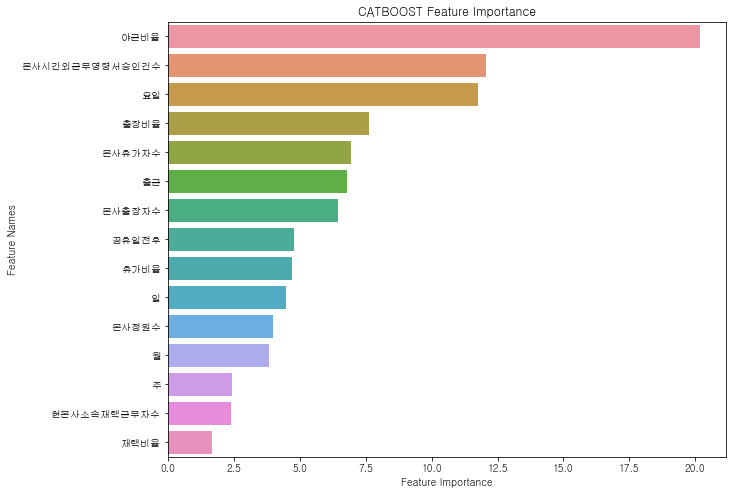

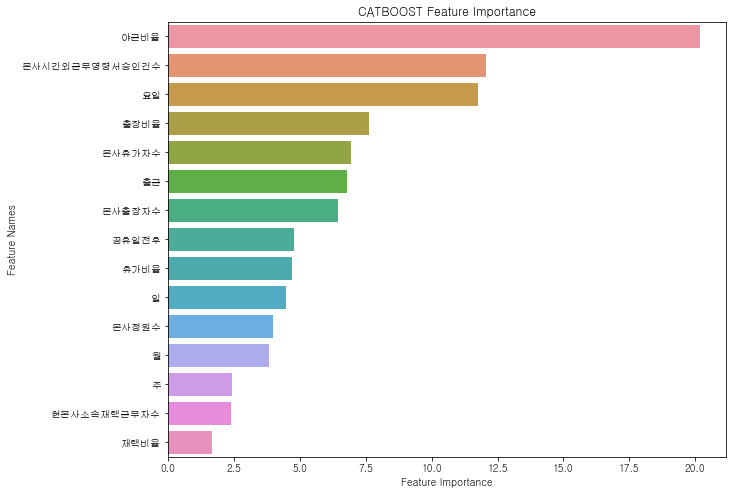

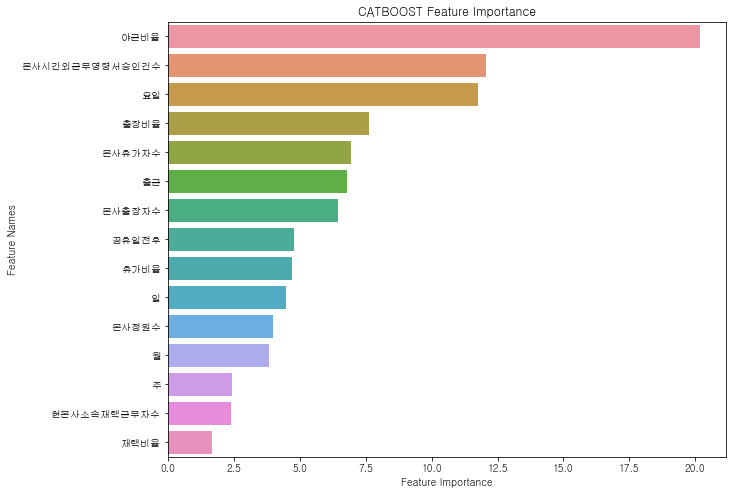

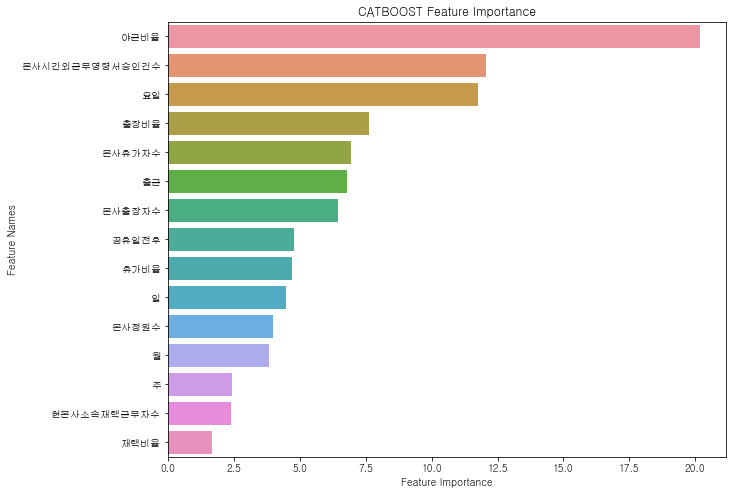

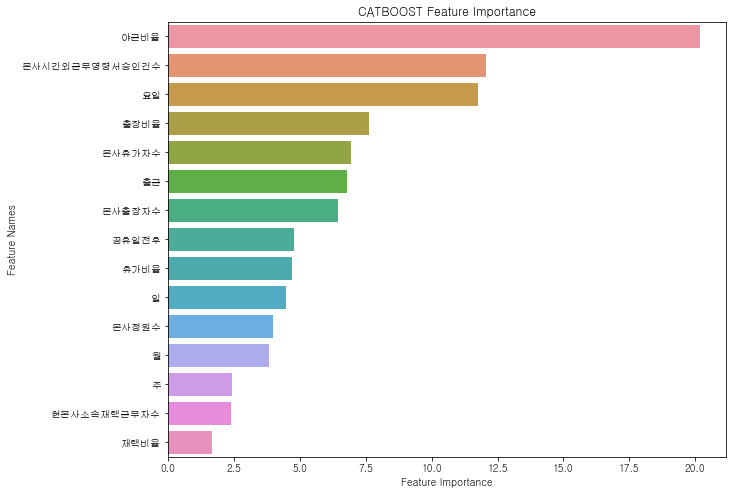

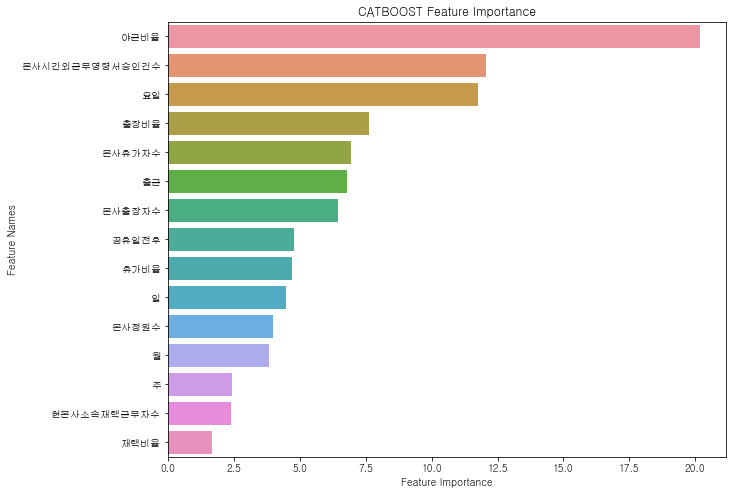

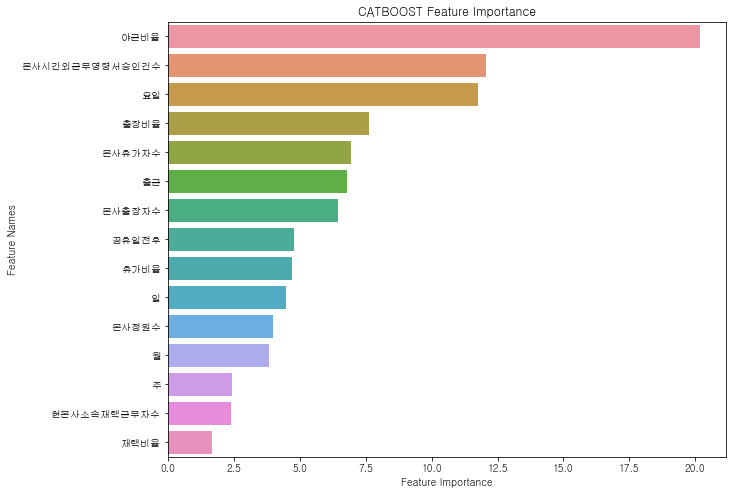

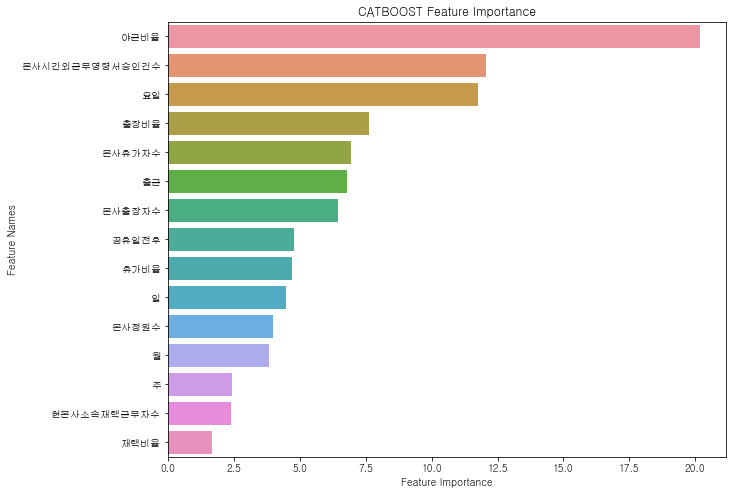

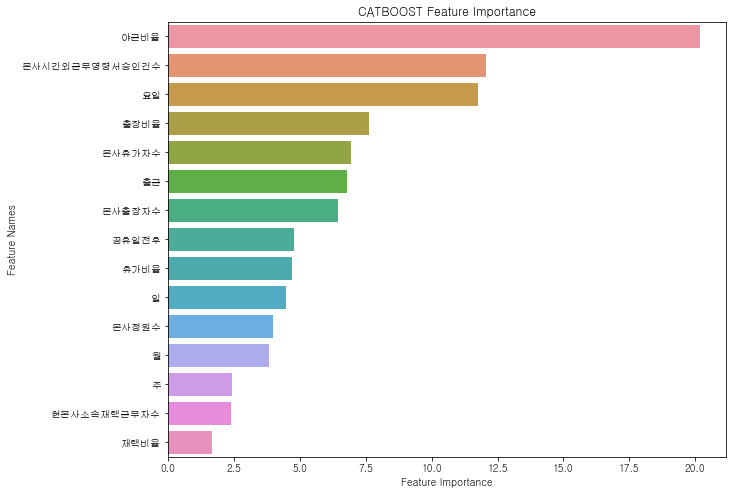

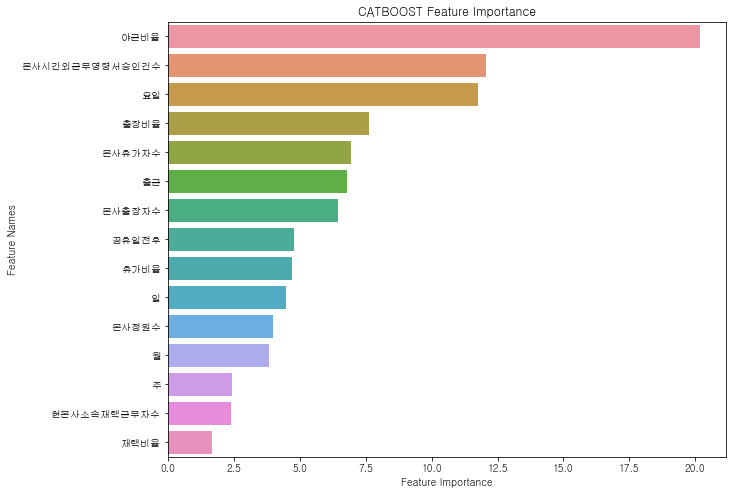

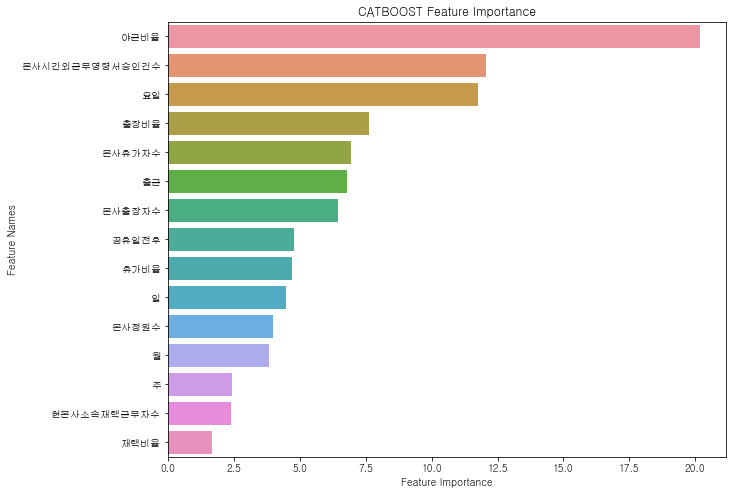

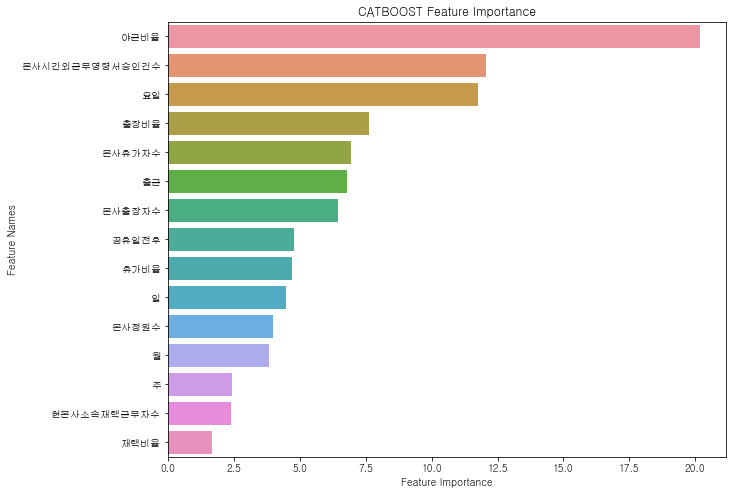

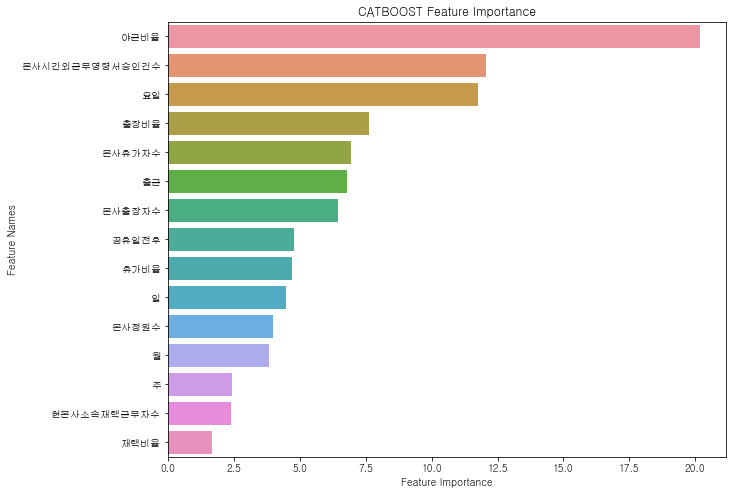

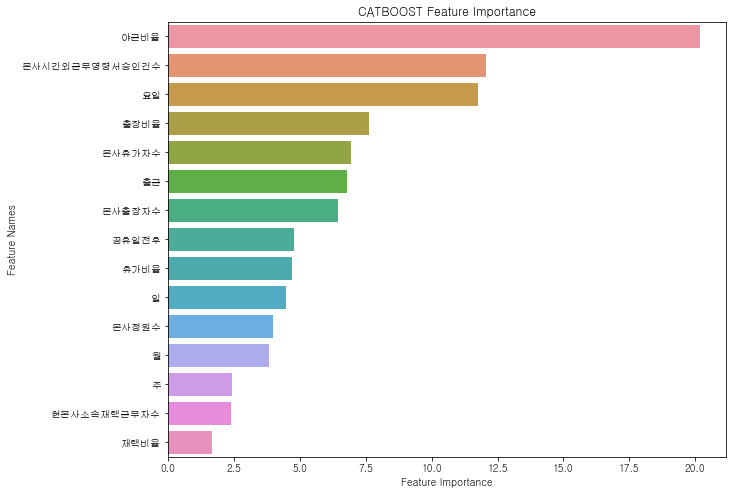

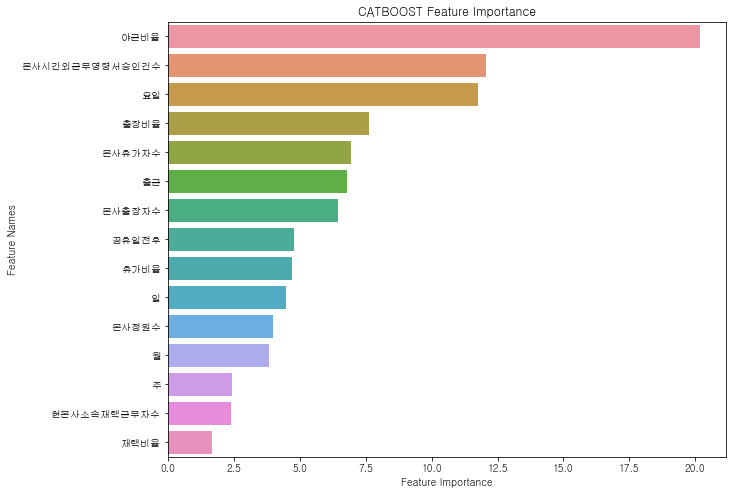

In [49]:
for i in range(n_fold):
    plot_feature_importance(dinner_models[0].get_feature_importance(),dinner_train.iloc[:,:-1].columns,"CATBOOST")